In [58]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [59]:
# workers = os.cpu_count()

In [60]:
train_df = pd.read_csv("C:/Users/LPA/Desktop/nlp_csv.csv")

In [108]:
train_df.tail()

,id,sex,age,location,history,vet
111,109,F,17,outpatient,previous scan showed 5cm simple cysts - can we...,C
112,110,F,19,outpatient,March 2023The left ovary contains a 48 x 33 x ...,D
113,111,F,82,outpatient,7 mm AML in right kidney. follow-up scan in 1...,D
114,112,M,75,outpatient,EVAR OCT 2008. Next scan January 2024.,D
115,113,M,71,outpatient,OA in 2nd MCPJ left hand. For steroid injectio...,C


In [62]:
val_x = pd.read_csv("C:/Users/LPA/Desktop/nlp_test.csv")

In [107]:
val_x.head()

,history,vet
0,"cirrhosis, HCC surveillance in mid October 202...",0
1,"know to have atypical complex hyperplasia, dec...",0
2,"54 yo, currently asymptomatic, on HRTS, previo...",0
3,Follow-up for gallbladder polyps in one year a...,0
4,right renal agenesis - surveillance,1


In [64]:
dfd = train_df[train_df['vet'] == 'D']
dfc = train_df[train_df['vet'] == 'C']

In [65]:
train_all = pd.concat([dfd, dfc], axis=0)

In [66]:
train_y = train_all['vet']

In [67]:
catnum = {'D': 0, 'C': 1}
numcat = {0: 'D', 1: 'C'}
train_y = train_y.map(catnum)

<Axes: xlabel='vet', ylabel='count'>

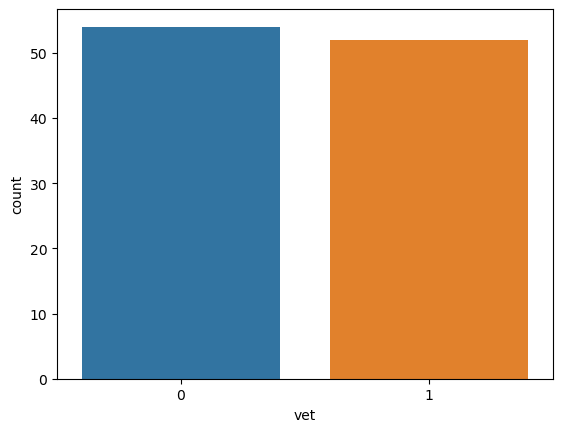

In [68]:
sns.countplot(x=train_y)

In [69]:
train_y.value_counts()

vet
0    54
1    52
Name: count, dtype: int64

In [70]:
train_x = train_all[['history', 'vet']]
train_x['vet'] = train_x['vet'].map(catnum)

C:\Users\LPA\AppData\Local\Temp\ipykernel_3828\90949853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x['vet'] = train_x['vet'].map(catnum)


In [71]:
val_x['vet'] = val_x['vet'].map(catnum)
val_x.head()

,history,vet
0,"cirrhosis, HCC surveillance in mid October 202...",0
1,"know to have atypical complex hyperplasia, dec...",0
2,"54 yo, currently asymptomatic, on HRTS, previo...",0
3,Follow-up for gallbladder polyps in one year a...,0
4,right renal agenesis - surveillance,1


In [72]:
train_x.reset_index(inplace=True)
train_x = train_x[['history', 'vet']]
train_x.head()

,history,vet
0,Please repeat USS in 1/52 due to right lower l...,0
1,follow up scan in 3 months time ovarian cysts.,0
2,"know to have atypical complex hyperplasia, dec...",0
3,Kidneys size discrepancy. Control US scan Very...,0
4,U4 thyroid nodule. Smaller on last US. For fol...,0


In [73]:
attributes = ['vet']

In [74]:
test_x = pd.read_csv('C:/Users/LPA/Desktop/nlp_test_wlabels.csv')

In [75]:
test_x['vet'] = test_x['vet'].map(catnum)
test_x.head()

,history,vet
0,aml 4mm needs follow up in 1 year,0
1,complex cyst in left testis. Another scan is n...,0
2,liver cirrhosis. HCC surveillance in 6 months,0
3,pain in RUQ ?gallstones,1
4,"pelvic pain for 2 months, ultrasound pelvis pl...",1


# Dataset

In [76]:
from torch.utils.data import Dataset

In [77]:
class Med_Dataset(Dataset):
    def __init__(self, data, tokenizer, attributes, max_token_len = 256):
        self.tokenizer = tokenizer
        self.attributes = attributes
        self.max_token_len = max_token_len
        self.data = data

    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):
        item = self.data.iloc[index]
        comment = str(item.history)
        attributes = torch.FloatTensor(item[self.attributes])
        tokens = self.tokenizer.encode_plus(comment,
                                            add_special_tokens=True,
                                            return_tensors='pt',
                                            truncation=True,
                                            padding='max_length',
                                            max_length=self.max_token_len,
                                            return_attention_mask = True)
        return {'input_ids': tokens.input_ids.flatten(), 'attention_mask': tokens.attention_mask.flatten(), 'labels': attributes}


In [78]:
# pip install transformers

In [79]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
med_ds = Med_Dataset(train_x, tokenizer, attributes=attributes)
med_ds_val = Med_Dataset(val_x, tokenizer, attributes=attributes)

In [80]:
med_ds.__getitem__(0)['labels'].shape, med_ds.__getitem__(0)['input_ids'].shape, med_ds.__getitem__(0)['attention_mask'].shape

(torch.Size([1]), torch.Size([256]), torch.Size([256]))

In [81]:
len(med_ds), len(med_ds_val)

(106, 19)

# Data module

In [82]:
# pip install pytorch_lightning

In [83]:
import pytorch_lightning as pl #This helps with module creation, for example model.train() or model.eval are no longer needed
from torch.utils.data import DataLoader

In [84]:
class Med_Data_Module(pl.LightningDataModule):

    def __init__(self, train, val, test, attributes, batch_size = 16, max_token_length = 256, model_name = 'medicalai/ClinicalBERT'):
        super().__init__()
        self.train = train
        self.val = val
        self.test = test
        self.attributes = attributes
        self.batch_size = batch_size
        self.max_token_length = max_token_length
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def setup(self, stage=None):
        if stage in (None, 'fit'):
            self.train_dataset = Med_Dataset(self.train, attributes=self.attributes, tokenizer=self.tokenizer)
            self.val_dataset = Med_Dataset(self.val, attributes=self.attributes, tokenizer=self.tokenizer)
        if stage == 'predict':
            self.test_dataset = Med_Dataset(self.test, attributes=self.attributes, tokenizer=self.tokenizer)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=0, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=0, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.test_dataset, batch_size = self.batch_size, num_workers=0, shuffle=False)

In [85]:
med_data_module = Med_Data_Module(train_x, val_x, test_x, attributes=attributes)

In [86]:
med_data_module.setup()

In [87]:
med_data_module.train_dataloader()

In [88]:
len(med_data_module.train_dataloader())

7

# Model

In [89]:
# from pytorch_lightning.loggers import WandbLogger

In [90]:
# pip install wandb

In [91]:
# wandb_logger = WandbLogger(log_model='all')

In [92]:
from transformers import AutoModel, AdamW, get_cosine_schedule_with_warmup
import math
from torchmetrics.functional.classification import auroc
import torch.nn.functional as F

In [93]:
from transformers.generation import logits_process
class Med_Vetting_Classifier(pl.LightningModule):

    def __init__(self, config: dict):
        super().__init__()
        self.config = config
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
        self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
        self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        self.loss_func = nn.BCEWithLogitsLoss(reduction='mean')
        self.dropout = nn.Dropout()

    def forward(self, input_ids, attention_mask, labels=None):
        # roberta layer
        output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = torch.mean(output.last_hidden_state, 1)
        # final logits
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.hidden(pooled_output)
        pooled_output = F.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        # calculate loss
        loss = 0
        if labels is not None:
            loss = self.loss_func(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
            return loss, logits

    def training_step(self, batch, batch_index):
        loss, outputs = self(**batch)
        self.log("train loss", loss, prog_bar = True, logger=True)
        return {"loss":loss, "predictions":outputs, "labels": batch["labels"]}

    def validation_step(self, batch, batch_index):
        loss, outputs = self(**batch)
        self.log("validation loss", loss, prog_bar = True, logger=True)
        return {"val_loss": loss, "predictions":outputs, "labels": batch["labels"]}

    def predict_step(self, batch, batch_index):
        loss, outputs = self(**batch)
        return outputs

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
        total_steps = self.config['train_size']/self.config['batch_size']
        warmup_steps = math.floor(total_steps * self.config['warmup'])
        warmup_steps = math.floor(total_steps * self.config['warmup'])
        scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer],[scheduler]

In [94]:
config = {
    'model_name': 'medicalai/ClinicalBERT',
    'n_labels': len(attributes),
    'batch_size': 16,
    'lr': 5e-5,
    'warmup': 0.2,
    'train_size': len(med_data_module.train_dataloader()),
    'weight_decay': 0.001,
    'n_epochs': 10
}

model = Med_Vetting_Classifier(config)

# Train model

In [95]:
idx = 0
input_ids = med_ds.__getitem__(idx)['input_ids']
am = med_ds.__getitem__(idx)['attention_mask']
labels = med_ds.__getitem__(idx)['labels']
loss, output = model(input_ids.unsqueeze(dim=0), am.unsqueeze(dim=0), labels.unsqueeze(dim=0))

In [96]:
loss, output

(tensor(0.6064, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 tensor([[-0.1817]], grad_fn=<AddmmBackward0>))

In [97]:
# pip install lightning[extra]

In [98]:
torch.set_float32_matmul_precision('medium')

In [99]:
# datamodule
med_data_module = Med_Data_Module(train_x, val_x, test_x, attributes=attributes, batch_size=config['batch_size'])
med_data_module.setup()

# model
model = Med_Vetting_Classifier(config)

# trainer and fit
trainer = pl.Trainer(max_epochs=config['n_epochs'], accelerator='cuda', devices=1, num_sanity_val_steps=2, log_every_n_steps=7)
trainer.fit(model, med_data_module)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type              | Params
-------------------------------------------------------
0 | pretrained_model | DistilBertModel   | 134 M 
1 | hidden           | Linear            | 590 K 
2 | classifier       | Linear            | 769   
3 | loss_func        | BCEWithLogitsLoss | 0     
4 | dropout          | Dropout           | 0     
-------------------------------------------------------
135 M     Trainable params
0         Non-trainable params
135 M     Total params
541.302   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\LPA\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\LPA\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [100]:
# %load_ext tensorboard
# %tensorboard --logdir ./lightning_logs/

# Predictions

In [101]:
def classify_raw_text(model, dm):
    predictions = trainer.predict(model, datamodule=dm)
    flattened_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])
    return flattened_predictions

In [102]:
model_test = classify_raw_text(model, med_data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\LPA\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [103]:
final = []
for i in model_test:
    if i <= 0.5:
        final.append('D')
    if i > 0.5:
        final.append('C')

print(final)

['D', 'D', 'D', 'C', 'C', 'C', 'C', 'C', 'D', 'C', 'D', 'D', 'D', 'D', 'C', 'D', 'D', 'C', 'C', 'C', 'C', 'C', 'C', 'D']


In [104]:
final_df = pd.DataFrame({'Prediction': final, 'Label': test_x['vet'].map(numcat)})

In [105]:
final_df

,Prediction,Label
0,D,D
1,D,D
2,D,D
3,C,C
4,C,C
5,C,C
6,C,C
7,C,C
8,D,D
9,C,C


In [106]:
from sklearn.metrics import accuracy_score, classification_report

test_accuracy = accuracy_score(test_x['vet'].map(numcat), final)
print(f"Test Accuracy: {test_accuracy:.4f}")

test_report = classification_report(test_x['vet'].map(numcat), final)
print("Classification Report:\n", test_report)

Test Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           C       1.00      1.00      1.00        13
           D       1.00      1.00      1.00        11

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

